In [17]:
import json
import string
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer

In [2]:
# Read DeClarE results from json file.
declareResults = pd.read_json("../data/Model_Results/DeClarE_Results.json", orient="index")

In [6]:
attentionDataDict = {}

for index, row in declareResults.iterrows():
    
    features = {}
        
    features["attentionWeights"] = row["attentionWeights"]
    features["veracity"] = row["veracity"]
    
    attentionDataDict[index] = features


In [7]:
attentionData = pd.DataFrame().from_dict(data = attentionDataDict, orient="index")

display(attentionData)

,attentionWeights,veracity
10000.json,"[average, than, feet, population, least, july,...",True
10054.json,"[ten, least, mexican, slipping]",False
10141.json,"[percent, billion, income, tax, deficits, debt...",True
10142.json,"[fell, rose, share, first, american, predicts,...",False
10200.json,"[million, benchmark, rate, unemployment, wages...",True
...,...,...
9507.json,"[year, rate, debt, fat, per, record, growth, t...",False
9547.json,"[tax, wage, rate, percent, billion, dollar, mi...",False
9652.json,"[thirds, than, million, premiums, average, pri...",True
9727.json,"[deficits, budget, share, jobs, than, rated, b...",False


In [8]:
x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/train.tsv', sep='\t')
x_trainDf.columns = ["json_id", "claim", "justification_label"]

x_testDf = pd.read_csv ('../data/Train_Eval_Test_Data/test.tsv', sep='\t')
x_testDf.columns = ["json_id", "claim", "justification_label"]

# x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/val.tsv', sep='\t')
# x_valDf.columns = ["json_id", "claim", "justification_label"]

FileNotFoundError: [Errno 2] No such file or directory: '../data/Train_Eval_Test_Data/train.tsv'

In [78]:
x_trainDf["attentionWeights"] = ""
x_testDf["attentionWeights"]  = ""
# x_valDf["attentionWeights"]   = ""

In [9]:
def addAttentionWeights(data, attention):

    for index, row in data.iterrows():
        if row["json_id"] in list(attentionData.index.values):
            row["attentionWeights"] = attention.loc[row["json_id"]]["attentionWeights"]

In [80]:
addAttentionWeights(x_trainDf, attentionData)
addAttentionWeights(x_testDf, attentionData)
# addAttentionWeights(x_valDf, attentionData)

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [19]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/vassilis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vassilis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
def cleanAndStemm(sentence):
    
    stop_words = set(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    
    sentenceList = []
    
    listReceived = False
    if type(sentence) is not list:
        sentence = sentence.split(' ')
    else:
        listReceived = True
        
    for token in sentence:
        
        token = token.lower()
        token = token.translate(str.maketrans('', '', string.punctuation))

        if token in stop_words:
            continue
        
        token = wordnet_lemmatizer.lemmatize(token)
        sentenceList.append(token)
    
    if listReceived:
        return sentenceList
    
    newSentence = ' '.join(sentenceList)
    return newSentence

In [82]:
y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
y_testDf  = pd.DataFrame(data=x_testDf["justification_label"])
# y_valDf   = pd.DataFrame(data=x_valDf["justification_label"])
# Create list containing claims + attention explanations

trainClaimAtt  = []
yTrainLabels   = y_trainDf['justification_label'].tolist()

testClaimAtt   = []
yTestLabels    = y_testDf['justification_label'].tolist()

# evalClaimAtt   = []
# yEvalLabels    = y_valDf['justification_label'].tolist()

for index, row in x_trainDf.iterrows():
    trainClaimAtt.append(cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights'])))

for index, row in x_testDf.iterrows():
    testClaimAtt.append(cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights'])))

# for index, row in x_valDf.iterrows():
#     evalClaimAtt.append(cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights'])))
    
# totalClaimAtt = trainClaimAtt + testClaimAtt + evalClaimAtt
# yTotalLabels = np.array(yTrainLabels + yTestLabels + yEvalLabels)

In [95]:
# Convert words to number using Bag of Words (Bow)
vectorizer = CountVectorizer(max_features=30, min_df=5, max_df=0.7)
vectorizedTrain = vectorizer.fit_transform(trainClaimAtt).toarray()
vectorizedTest  = vectorizer.fit_transform(testClaimAtt).toarray()
# vectorizedEval  = vectorizer.fit_transform(evalClaimAtt).toarray()
# vectorizedTotal = vectorizer.fit_transform(totalClaimAtt).toarray()

# Convert Bow values according to TfIdf
tfidfconverter = TfidfTransformer()
XTrain = tfidfconverter.fit_transform(vectorizedTrain).toarray()
XTest  = tfidfconverter.fit_transform(vectorizedTest).toarray()
# XEval  = tfidfconverter.fit_transform(vectorizedEval).toarray()
# XTotal = tfidfconverter.fit_transform(vectorizedTotal).toarray()

In [25]:
def TenFoldValidation_BowTfIdf(summarisationData, classifier):
    
    accuracyResults = np.zeros([10])
        
    for counter in range(10):
        x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/train' + str(counter + 1) + '.tsv', sep='\t')
        x_trainDf.columns = ["json_id", "claim", "justification_label"]

        x_testDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/test' + str(counter + 1) + '.tsv', sep='\t')
        x_testDf.columns = ["json_id", "claim", "justification_label"]
        
        x_trainDf["attentionWeights"] = ""
        x_testDf["attentionWeights"]  = ""
        
        addAttentionWeights(x_trainDf, attentionData)
        addAttentionWeights(x_testDf, attentionData)
        
        y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
        y_testDf  = pd.DataFrame(data=x_testDf["justification_label"])
        
        trainClaimAtt  = []
        yTrainLabels   = y_trainDf['justification_label'].tolist()

        testClaimAtt   = []
        yTestLabels    = y_testDf['justification_label'].tolist()

        for index, row in x_trainDf.iterrows():
            trainClaimAtt.append(cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights'])))

        for index, row in x_testDf.iterrows():
            testClaimAtt.append(cleanAndStemm(row['claim']) + ' '.join(cleanAndStemm(row['attentionWeights'])))
            
        # Convert words to number using Bag of Words (Bow)
        vectorizer = CountVectorizer(max_features=30)
        vectorizedTrain = vectorizer.fit_transform(trainClaimAtt).toarray()
        vectorizedTest  = vectorizer.fit_transform(testClaimAtt).toarray()

        # Convert Bow values according to TfIdf
        tfidfconverter = TfidfTransformer()
        XTrain = tfidfconverter.fit_transform(vectorizedTrain).toarray()
        XTest  = tfidfconverter.fit_transform(vectorizedTest).toarray()

        classifier.fit(XTrain,yTrainLabels)

        yPredLabels = classifier.predict(XTest)
        
        accuracyScore = accuracy_score(yTestLabels,yPredLabels)
        accuracyResults[counter] = accuracyScore

        ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
#         print(classification_report(yTestLabels,yPredLabels))
        print("Iteration:",counter+1," Accuracy Score: ",accuracyScore)
    
    return accuracyResults, np.mean(accuracyResults)

              precision    recall  f1-score   support

  distortion       0.12      0.12      0.12         8
    emphasis       0.00      0.00      0.00         9
   unfounded       0.12      0.12      0.12         8

    accuracy                           0.08        25
   macro avg       0.08      0.08      0.08        25
weighted avg       0.08      0.08      0.08        25

0.08


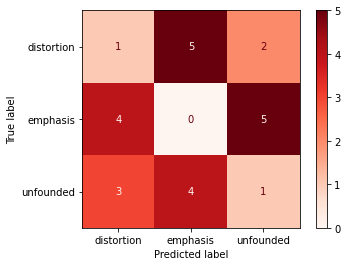

In [85]:
from sklearn.dummy import DummyClassifier

# Dummy Classifier With Method Stratified
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(XTrain, yTrainLabels)

yPredLabels = dummy_clf.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Reds')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))


---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.23076923076923078
Iteration: 2  Accuracy Score:  0.46153846153846156
Iteration: 3  Accuracy Score:  0.23076923076923078
Iteration: 4  Accuracy Score:  0.4166666666666667
Iteration: 5  Accuracy Score:  0.25
Iteration: 6  Accuracy Score:  0.4166666666666667
Iteration: 7  Accuracy Score:  0.5
Iteration: 8  Accuracy Score:  0.3333333333333333
Iteration: 9  Accuracy Score:  0.4166666666666667
Iteration: 10  Accuracy Score:  0.4166666666666667
Mean Accuracy:  0.3673076923076923


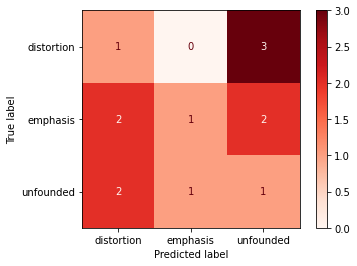

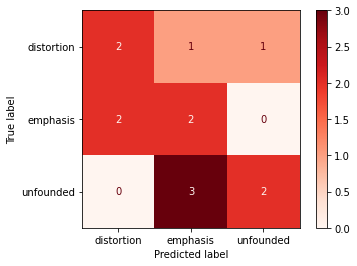

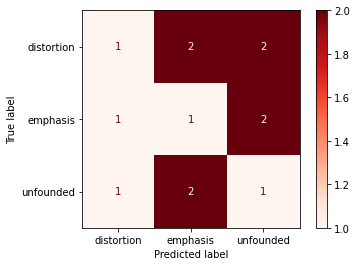

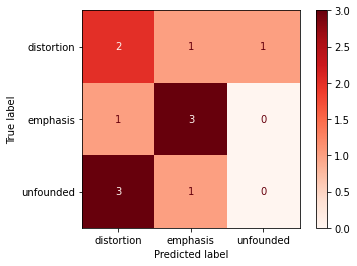

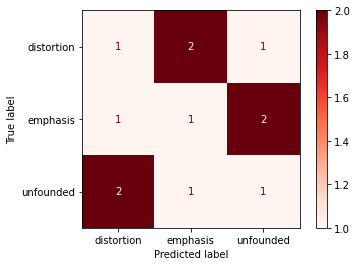

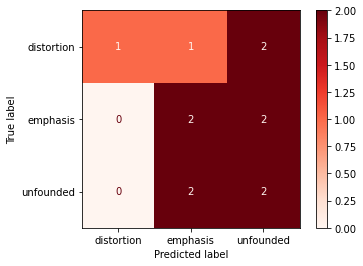

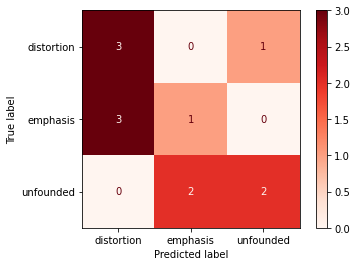

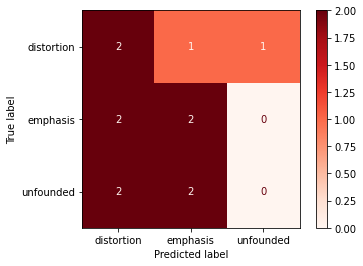

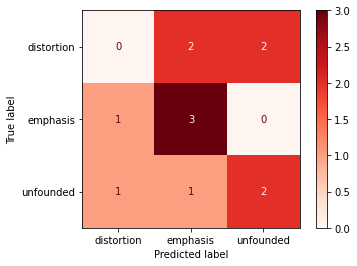

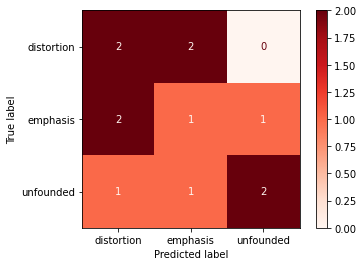

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classification Method
print("\n---- Bow - Tf-Idf Results----\n")
randForestClas = RandomForestClassifier(n_estimators=1000, random_state=0)
accuracyArrayX, meanAccuracyX = TenFoldValidation_BowTfIdf(attentionData, randForestClas)
print("Mean Accuracy: ", meanAccuracyX)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# K-Neighbors Classifier
print("\n---- Bow - Tf-Idf Results----\n")
kNeighborsClas = KNeighborsClassifier(n_neighbors=3)
accuracyArrayX, meanAccuracyX = TenFoldValidation_BowTfIdf(attentionData, kNeighborsClas)
print("Mean Accuracy: ", meanAccuracyX)


---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.3076923076923077
Iteration: 2  Accuracy Score:  0.15384615384615385
Iteration: 3  Accuracy Score:  0.15384615384615385
Iteration: 4  Accuracy Score:  0.3333333333333333
Iteration: 5  Accuracy Score:  0.4166666666666667
Iteration: 6  Accuracy Score:  0.4166666666666667
Iteration: 7  Accuracy Score:  0.5
Iteration: 8  Accuracy Score:  0.5
Iteration: 9  Accuracy Score:  0.3333333333333333
Iteration: 10  Accuracy Score:  0.3333333333333333
Mean Accuracy:  0.34487179487179487


In [24]:
from sklearn.svm import SVC

# SVM Classifier
print("\n---- Bow - Tf-Idf Results----\n")
svmClas = SVC()
accuracyArrayX, meanAccuracyX = TenFoldValidation_BowTfIdf(attentionData, svmClas)
print("Mean Accuracy: ", meanAccuracyX)


---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.23076923076923078
Iteration: 2  Accuracy Score:  0.5384615384615384
Iteration: 3  Accuracy Score:  0.15384615384615385
Iteration: 4  Accuracy Score:  0.4166666666666667
Iteration: 5  Accuracy Score:  0.4166666666666667
Iteration: 6  Accuracy Score:  0.4166666666666667
Iteration: 7  Accuracy Score:  0.3333333333333333
Iteration: 8  Accuracy Score:  0.5833333333333334
Iteration: 9  Accuracy Score:  0.3333333333333333
Iteration: 10  Accuracy Score:  0.4166666666666667
Mean Accuracy:  0.38397435897435894



---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.3076923076923077
Iteration: 2  Accuracy Score:  0.38461538461538464
Iteration: 3  Accuracy Score:  0.23076923076923078
Iteration: 4  Accuracy Score:  0.4166666666666667
Iteration: 5  Accuracy Score:  0.3333333333333333
Iteration: 6  Accuracy Score:  0.3333333333333333
Iteration: 7  Accuracy Score:  0.25
Iteration: 8  Accuracy Score:  0.4166666666666667
Iteration: 9  Accuracy Score:  0.3333333333333333
Iteration: 10  Accuracy Score:  0.3333333333333333
Mean Accuracy:  0.333974358974359


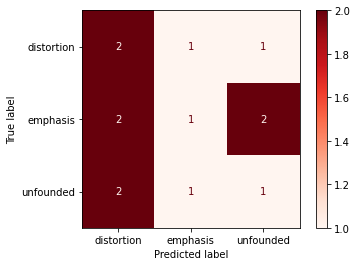

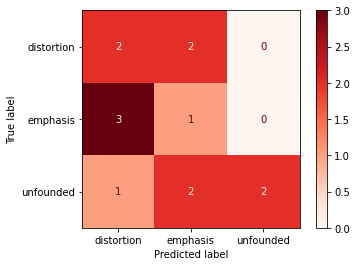

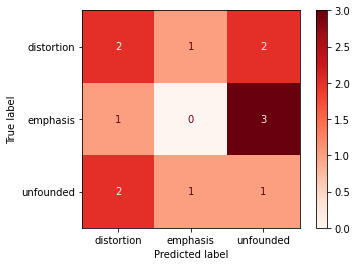

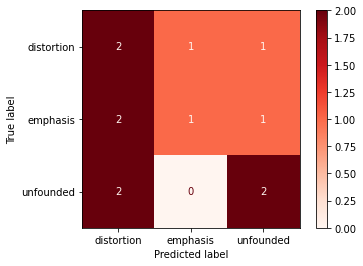

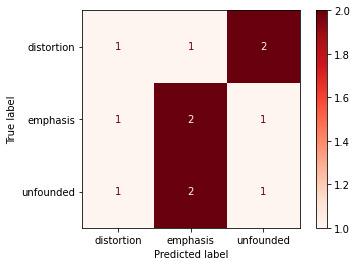

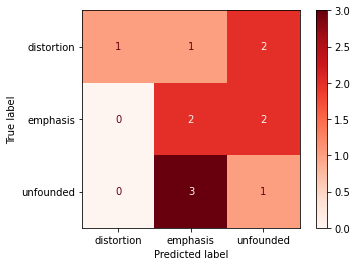

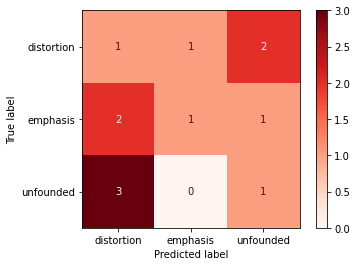

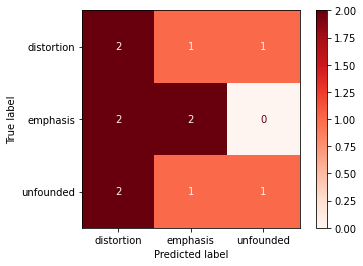

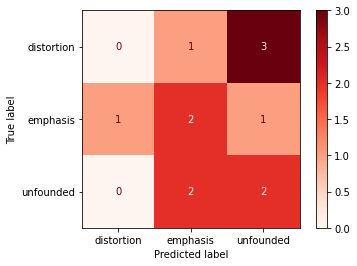

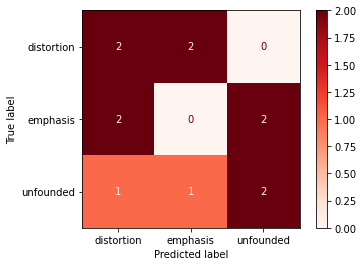

In [27]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Gaussian Process Classifier
print("\n---- Bow - Tf-Idf Results----\n")
gaussianProcClas = GaussianProcessClassifier()
accuracyArrayX, meanAccuracyX = TenFoldValidation_BowTfIdf(attentionData, gaussianProcClas)
print("Mean Accuracy: ", meanAccuracyX)


---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.3076923076923077
Iteration: 2  Accuracy Score:  0.23076923076923078
Iteration: 3  Accuracy Score:  0.5384615384615384
Iteration: 4  Accuracy Score:  0.3333333333333333
Iteration: 5  Accuracy Score:  0.3333333333333333
Iteration: 6  Accuracy Score:  0.3333333333333333
Iteration: 7  Accuracy Score:  0.25
Iteration: 8  Accuracy Score:  0.3333333333333333
Iteration: 9  Accuracy Score:  0.08333333333333333
Iteration: 10  Accuracy Score:  0.4166666666666667
Mean Accuracy:  0.31602564102564107


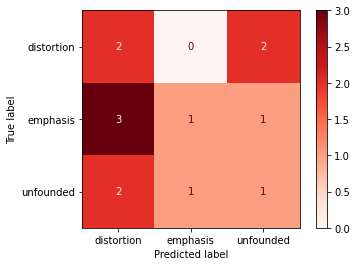

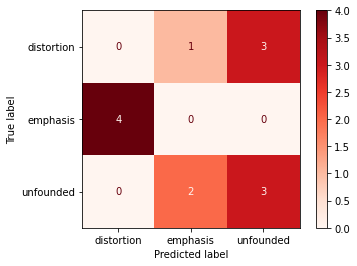

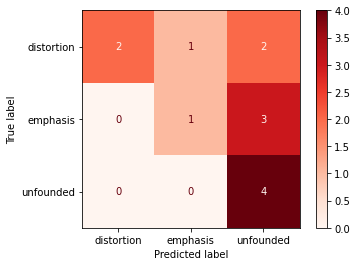

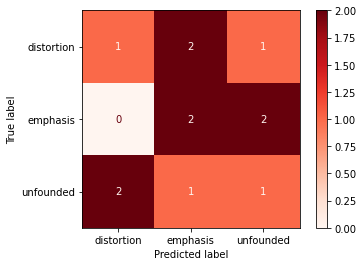

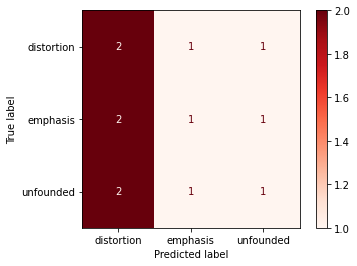

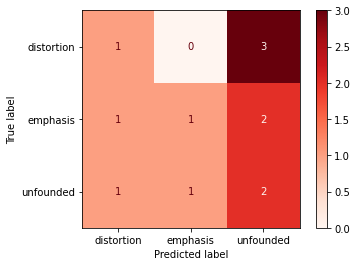

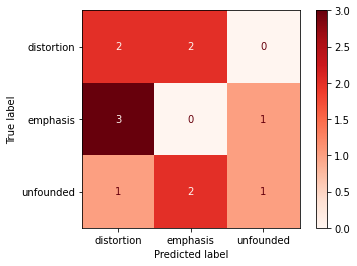

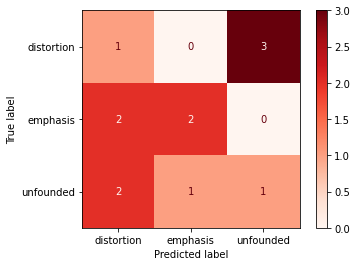

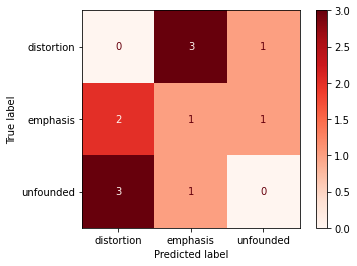

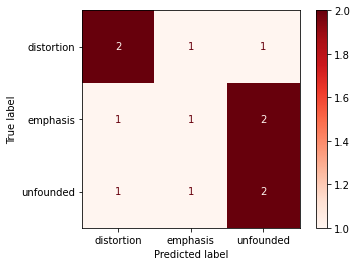

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
print("\n---- Bow - Tf-Idf Results----\n")
decisionTreeClas = DecisionTreeClassifier()
accuracyArrayX, meanAccuracyX = TenFoldValidation_BowTfIdf(attentionData, decisionTreeClas)
print("Mean Accuracy: ", meanAccuracyX)


---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.38461538461538464
Iteration: 2  Accuracy Score:  0.3076923076923077
Iteration: 3  Accuracy Score:  0.23076923076923078
Iteration: 4  Accuracy Score:  0.16666666666666666
Iteration: 5  Accuracy Score:  0.3333333333333333
Iteration: 6  Accuracy Score:  0.16666666666666666
Iteration: 7  Accuracy Score:  0.16666666666666666
Iteration: 8  Accuracy Score:  0.5
Iteration: 9  Accuracy Score:  0.25
Iteration: 10  Accuracy Score:  0.4166666666666667
Mean Accuracy:  0.29230769230769227


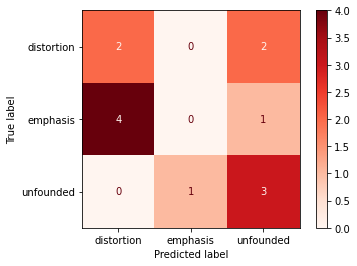

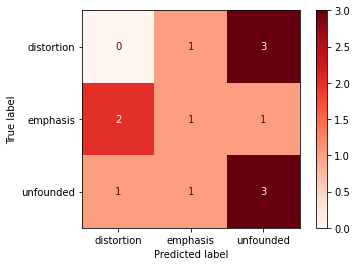

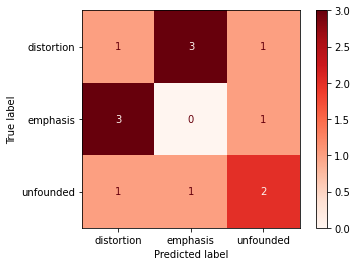

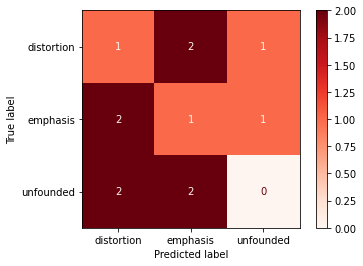

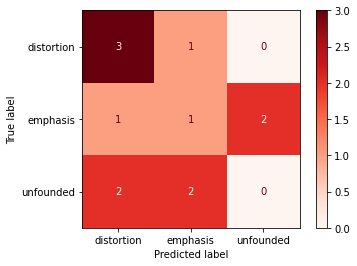

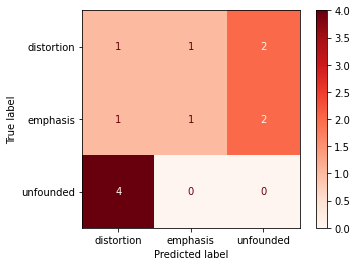

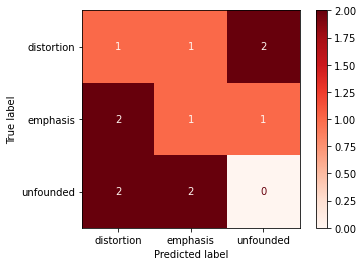

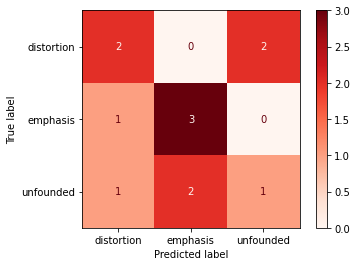

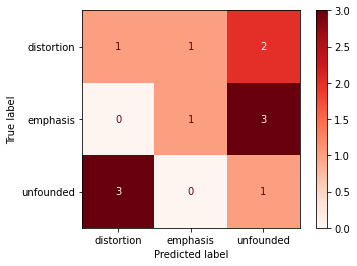

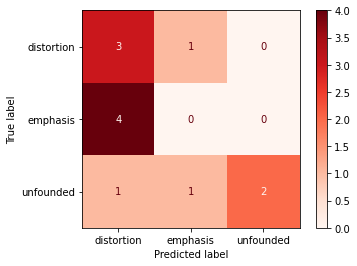

In [29]:
from sklearn.ensemble import AdaBoostClassifier

# Ada Boost Classifier
print("\n---- Bow - Tf-Idf Results----\n")
adaBoostClas = AdaBoostClassifier()
accuracyArrayX, meanAccuracyX = TenFoldValidation_BowTfIdf(attentionData, adaBoostClas)
print("Mean Accuracy: ", meanAccuracyX)


---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.38461538461538464
Iteration: 2  Accuracy Score:  0.46153846153846156
Iteration: 3  Accuracy Score:  0.3076923076923077
Iteration: 4  Accuracy Score:  0.08333333333333333
Iteration: 5  Accuracy Score:  0.3333333333333333
Iteration: 6  Accuracy Score:  0.5
Iteration: 7  Accuracy Score:  0.25
Iteration: 8  Accuracy Score:  0.4166666666666667
Iteration: 9  Accuracy Score:  0.3333333333333333
Iteration: 10  Accuracy Score:  0.4166666666666667
Mean Accuracy:  0.3487179487179487


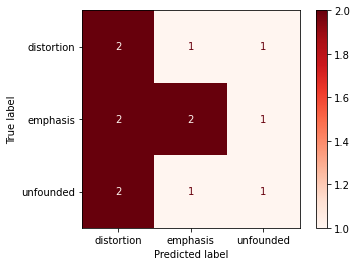

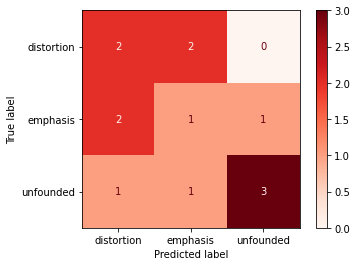

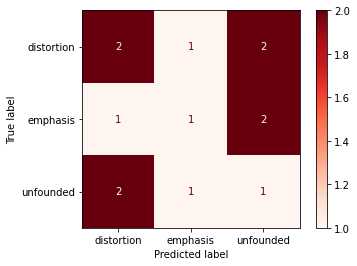

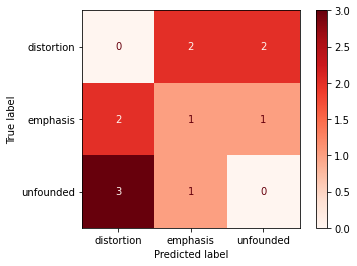

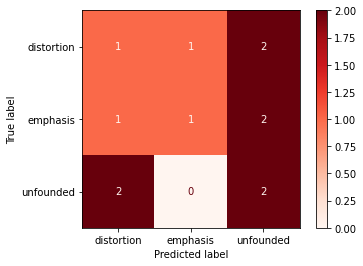

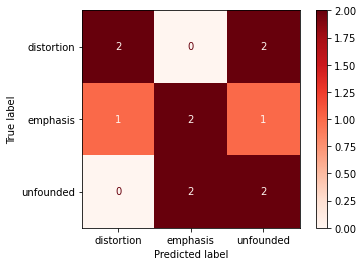

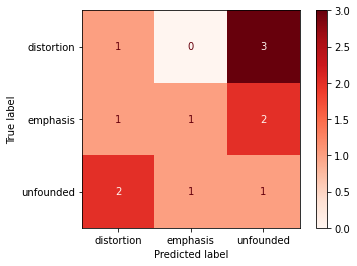

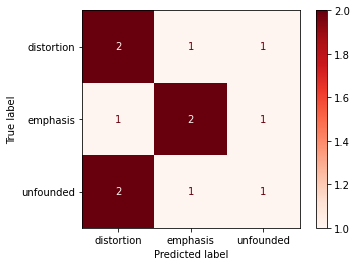

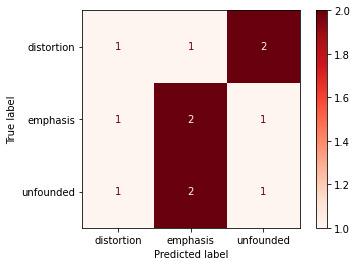

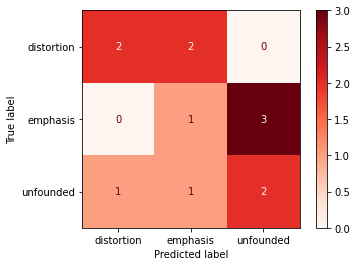

In [31]:
from sklearn.naive_bayes import MultinomialNB
# Multinomial Naive Bayes Classifier
print("\n---- Bow - Tf-Idf Results----\n")
multiNBClas = MultinomialNB()
accuracyArrayX, meanAccuracyX = TenFoldValidation_BowTfIdf(attentionData, multiNBClas)
print("Mean Accuracy: ", meanAccuracyX)


---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.23076923076923078
Iteration: 2  Accuracy Score:  0.5384615384615384
Iteration: 3  Accuracy Score:  0.46153846153846156
Iteration: 4  Accuracy Score:  0.16666666666666666
Iteration: 5  Accuracy Score:  0.4166666666666667
Iteration: 6  Accuracy Score:  0.3333333333333333
Iteration: 7  Accuracy Score:  0.25
Iteration: 8  Accuracy Score:  0.5
Iteration: 9  Accuracy Score:  0.3333333333333333
Iteration: 10  Accuracy Score:  0.25
Mean Accuracy:  0.34807692307692306


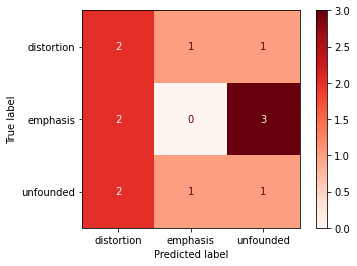

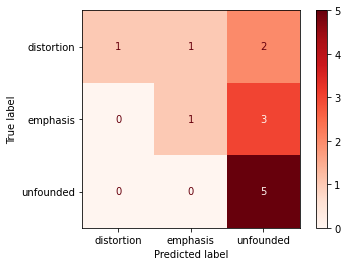

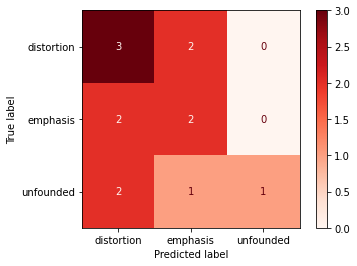

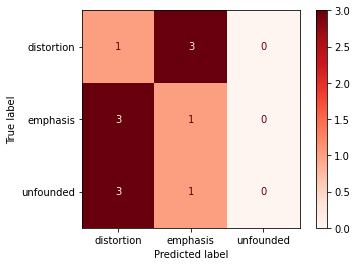

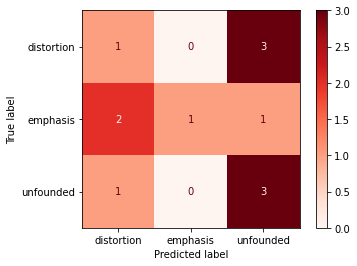

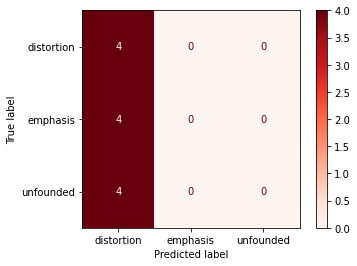

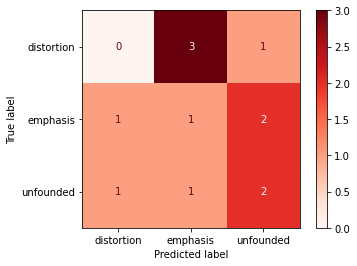

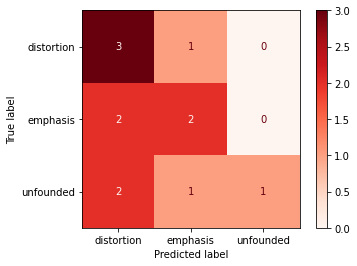

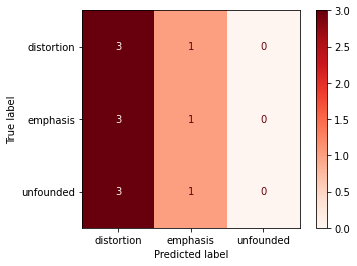

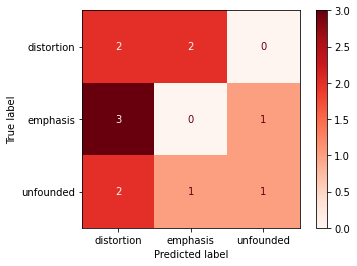

In [32]:
from sklearn.linear_model import SGDClassifier
# Multinomial Naive Bayes Classifier
print("\n---- Bow - Tf-Idf Results----\n")
sgdClas = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None)
accuracyArrayX, meanAccuracyX = TenFoldValidation_BowTfIdf(attentionData, sgdClas)
print("Mean Accuracy: ", meanAccuracyX)


---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.23076923076923078
Iteration: 2  Accuracy Score:  0.5384615384615384
Iteration: 3  Accuracy Score:  0.23076923076923078
Iteration: 4  Accuracy Score:  0.25
Iteration: 5  Accuracy Score:  0.3333333333333333
Iteration: 6  Accuracy Score:  0.25
Iteration: 7  Accuracy Score:  0.25
Iteration: 8  Accuracy Score:  0.4166666666666667
Iteration: 9  Accuracy Score:  0.3333333333333333
Iteration: 10  Accuracy Score:  0.3333333333333333
Mean Accuracy:  0.3166666666666667


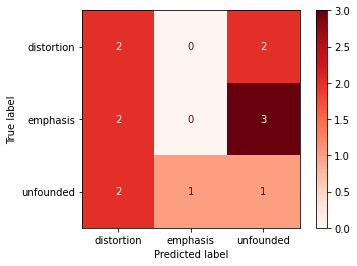

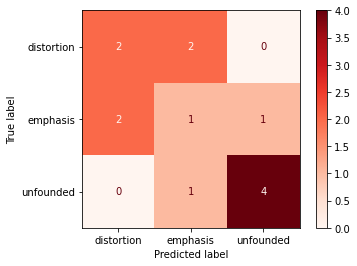

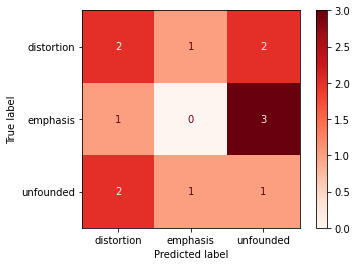

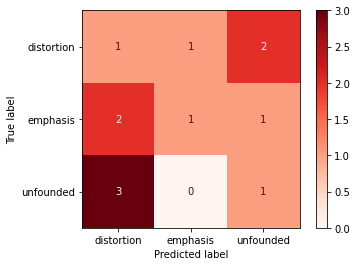

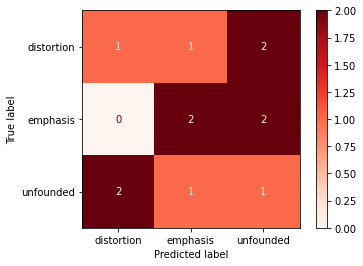

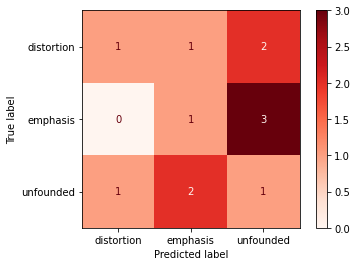

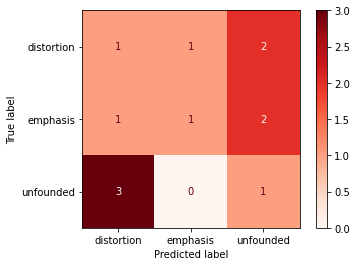

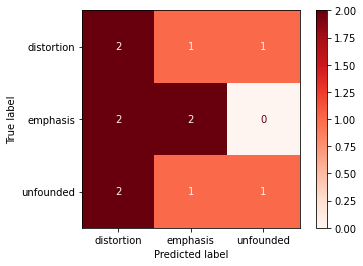

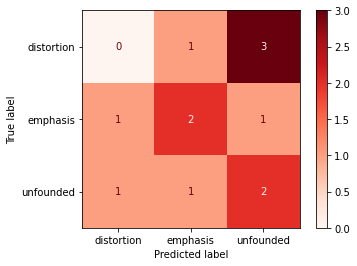

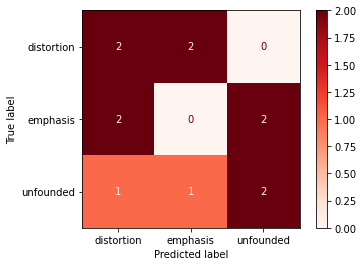

In [33]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
print("\n---- Bow - Tf-Idf Results----\n")
logRegClas = LogisticRegression()
accuracyArrayX, meanAccuracyX = TenFoldValidation_BowTfIdf(attentionData, logRegClas)
print("Mean Accuracy: ", meanAccuracyX)